

## Reinforcement Learning
---

HW-3

Dueling_DQN


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/RL2023/HW3
!ls


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/RL2023/HW3
duel_dqn.pt  HW3_Code.ipynb


In [2]:
import sys; sys.path.append('..') # add project root to the python path
# !pip install swig
# !pip install gymnasium
# !pip install gymnasium[box2d]
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output

In [3]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


## Check the Video

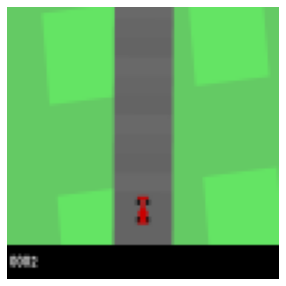

In [4]:
env.reset()
frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

# Preprocess the Image

In [5]:
# Every frme always contains a black area at the bottom of the frame, so we had better cut this black area.
# Also, Color imformation is not directly related to car racing. So we will use gray image for computation efficiency.

def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

# Manual Environment

In [6]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
    
    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
        
        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

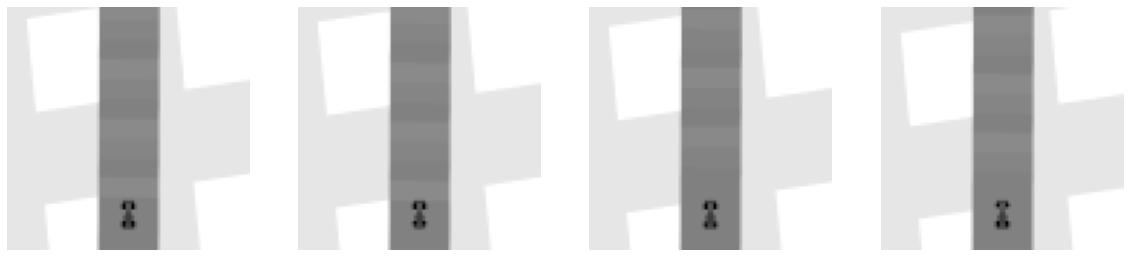

In [7]:
"""
0: do nothing
1: steer left
2: steer right
3: steer gas
4: brake
"""
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

env.reset()
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()



# Network

### ouput tensor size of Convolution layer

- $O$ : Size(width) of output image
- $I$: Size(width) of input image
- $K$: Size(width) of kernels used in the Conv layer
- $N$: Number of kernels
- $S$: Stride of the convolution operation
- $P$: Padding size

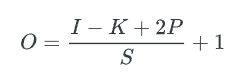

# Homework 3-1, 3-2 

In [8]:
class Net(nn.Module):

    def __init__(self, state_dim, action_dim):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)  # [N,4,84,84] -> [N,16,20,20]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.in_features = 32 * 9 * 9

        # Homework 3-1
        # Implementation of advantage_layer and value_layer
        # 
        # Example
        # self.advantage_layer=nn.Sequential(
        # 
        # )
        # 
        # self.value_layer=nn.Sequential(
        # 
        # )
        self.advantage_layer=nn.Sequential(
            nn.Linear(self.in_features,256),
            nn.Linear(256,256),
            nn.Linear(256,action_dim)
        )
        self.value_layer=nn.Sequential(
            nn.Linear(self.in_features,256),
            nn.Linear(256,256),
            nn.Linear(256,1)
        )



    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view((-1, self.in_features))

        advantage= self.advantage_layer(x)
        value = self.value_layer(x).expand_as(advantage)

        #  Homework 3-2
        # Calculate q using advantage and value
        # using subtract mean
        # 
        # Example
        # q = ...
        q = value + advantage - advantage.mean(1, keepdim=True).expand_as(advantage)

        return q

# Replay Buffer

In [9]:
class ReplayBuffer:

  def __init__(self,state_dim,action_dim,max_size=int(1e5)):
    self.s=np.zeros((max_size,*state_dim),dtype=np.float32)
    self.a=np.zeros((max_size,*action_dim),dtype=np.int64)
    self.r=np.zeros((max_size,1),dtype=np.float32)
    self.ns=np.zeros((max_size,*state_dim),dtype=np.float32)
    self.done=np.zeros((max_size,1),dtype=np.float32)


    self.ptr=0
    self.size=0
    self.max_size=max_size

  def update(self, s, a, r, ns, done):
      self.s[self.ptr] = s
      self.a[self.ptr] = a
      self.r[self.ptr] = r
      self.ns[self.ptr] = ns
      self.done[self.ptr] = done
      
      self.ptr = (self.ptr + 1) % self.max_size
      self.size = min(self.size + 1, self.max_size)
      
  def sample(self, batch_size):
      ind = np.random.randint(0, self.size, batch_size)
      return (
          torch.FloatTensor(self.s[ind]),
          torch.FloatTensor(self.a[ind]),
          torch.FloatTensor(self.r[ind]),
          torch.FloatTensor(self.ns[ind]),
          torch.FloatTensor(self.done[ind]), 
      )

# Dueling DQN

[Z. Wang et al., "Dueling Network Architectures for Deep Reinforcement Learning." arXiv preprint arXiv:1511.06581, 2015.](https://arxiv.org/pdf/1511.06581.pdf)

The proposed network architecture, which is named *dueling architecture*, explicitly separates the representation of state values and (state-dependent) action advantages. 

![fig1](https://user-images.githubusercontent.com/14961526/60322956-c2f0b600-99bb-11e9-9ed4-443bd14bc3b0.png)

The dueling network automatically produces separate estimates of the state value function and advantage function, without any extra supervision. Intuitively, the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state. This is particularly useful in states where its actions do not affect the environment in any relevant way. 

The dueling architecture represents both the value $V(s)$ and advantage $A(s, a)$ functions with a single deep model whose output combines the two to produce a state-action value $Q(s, a)$. Unlike in advantage updating, the representation and algorithm are decoupled by construction.

$$A^\pi (s, a) = Q^\pi (s, a) - V^\pi (s).$$

The value function $V$ measures the how good it is to be in a particular state $s$. The $Q$ function, however, measures the the value of choosing a particular action when in this state. Now, using the definition of advantage, we might be tempted to construct the aggregating module as follows:

$$Q(s, a; \theta, \alpha, \beta) = V (s; \theta, \beta) + A(s, a; \theta, \alpha),$$

where $\theta$ denotes the parameters of the convolutional layers, while $\alpha$ and $\beta$ are the parameters of the two streams of fully-connected layers.

Unfortunately, the above equation is unidentifiable in the sense that given $Q$ we cannot recover $V$ and $A$ uniquely; for example, there are uncountable pairs of $V$ and $A$ that make $Q$ values to zero. To address this issue of identifiability, we can force the advantage function estimator to have zero advantage at the chosen action. That is, we let the last module of the network implement the forward mapping.

$$
Q(s, a; \theta, \alpha, \beta) = V (s; \theta, \beta) + \big( A(s, a; \theta, \alpha) - \max_{a' \in |\mathcal{A}|} A(s, a'; \theta, \alpha) \big).
$$

This formula guarantees that we can recover the unique $V$ and $A$, but the optimization is not so stable because the advantages have to compensate any change to the optimal action’s advantage. Due to the reason, an alternative module that replaces the max operator with an average is proposed:

$$
Q(s, a; \theta, \alpha, \beta) = V (s; \theta, \beta) + \big( A(s, a; \theta, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; \theta, \alpha) \big).
$$

Unlike the max advantage form, in this formula, the advantages only need to change as fast as the mean, so it increases the stability of optimization.



In [10]:

class Dueling_DQN:
    def __init__(
            self,
            state_dim,
            action_dim,
            lr=0.00025,
            epsilon=1.0,
            epsilon_min=0.1,
            gamma=0.99,
            batch_size=32,
            warmup_steps=5000,
            buffer_size=int(1e5),
            target_update_interval=10000,
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.Q = Net(state_dim[0], action_dim)
        self.target_Q = Net(state_dim[0], action_dim)
        self.target_Q.load_state_dict(self.Q.state_dict())
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1,), buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.Q.to(self.device)
        self.target_Q.to(self.device)

        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6

    def select_action(self, x, training=True):

        # Exploration case
        # 1. Epsilon Greedy
        # 2. training (If evaluation, Just Greedy)
        # 3. warmup-steps
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            q = self.Q(x)
            a = torch.argmax(q,dim=1,keepdim=True).item()
        return a

    def update_model(self):

        s, a, r, ns, done = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))

        next_q = self.target_Q(ns).detach()
        td_target = r + (1. - done) * self.gamma * next_q.max(dim=-1, keepdim=True).values

        td_error = F.mse_loss(self.Q(s).gather(1, a.long()), td_target)
        self.optimizer.zero_grad()
        td_error.backward()
        self.optimizer.step()

    def process(self, transition):

        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            self.update_model()

        if self.total_steps % self.target_update_interval == 0:
            self.target_Q.load_state_dict(self.Q.state_dict())
        self.epsilon -= self.epsilon_decay

# Training

In [11]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = int(2e6)
eval_interval = 10000
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = Dueling_DQN(state_dim, action_dim)

In [12]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    max_score = 0
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.select_action(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
        if ret > max_score:
          max_score = ret
    return max_score

Steps: 10000  AvgReturn: 119.03508771930251


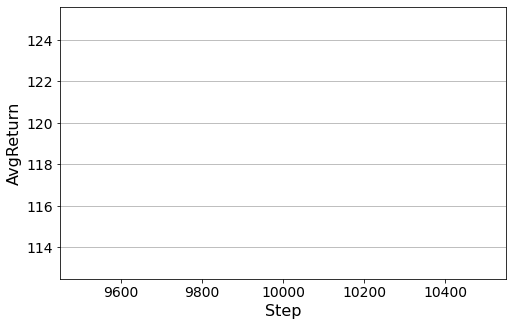

Steps: 20000  AvgReturn: 0


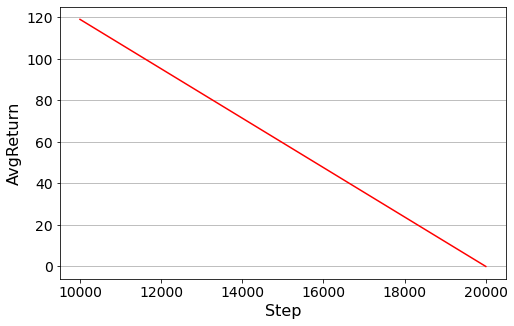

Steps: 30000  AvgReturn: 0


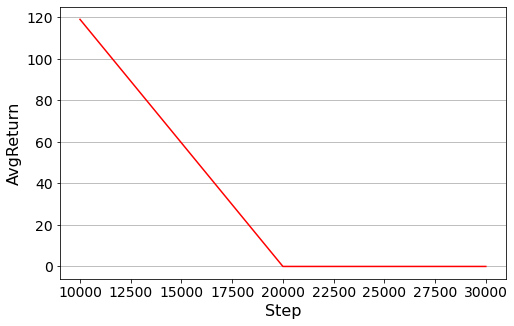

Steps: 40000  AvgReturn: 0


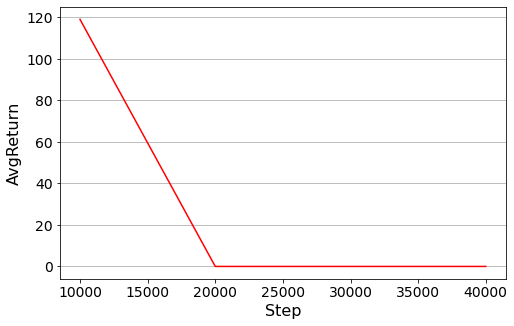

Steps: 50000  AvgReturn: 0


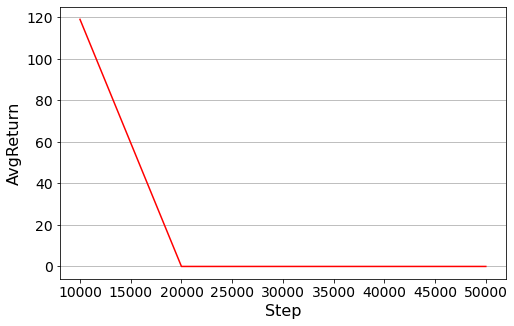

Steps: 60000  AvgReturn: 0


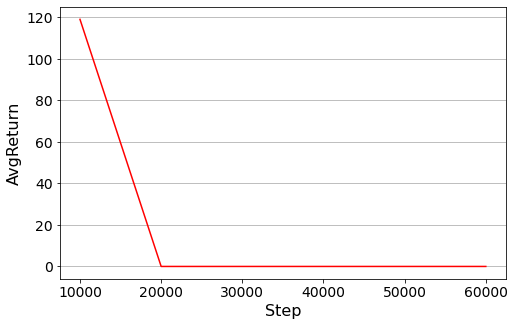

Steps: 70000  AvgReturn: 5.3460207612456845


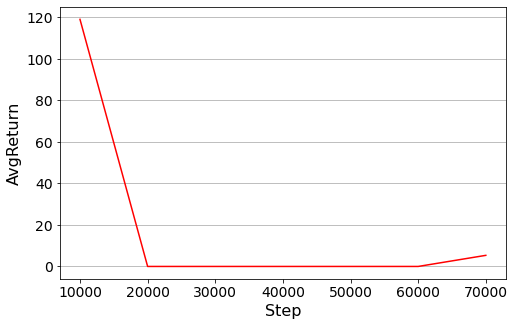

Steps: 80000  AvgReturn: 0


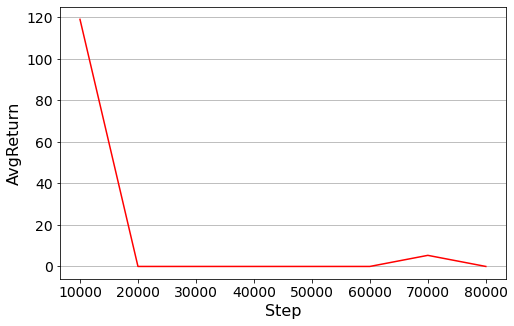

Steps: 90000  AvgReturn: 33.301886792451775


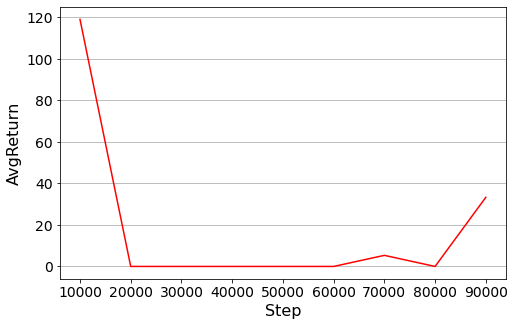

Steps: 100000  AvgReturn: 0


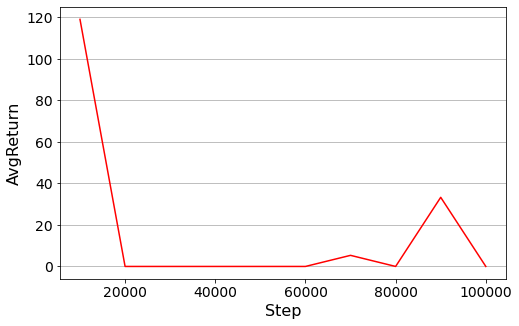

Steps: 110000  AvgReturn: 40.384615384614634


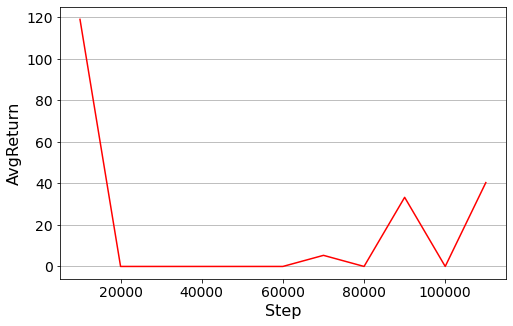

Steps: 120000  AvgReturn: 32.03583061889319


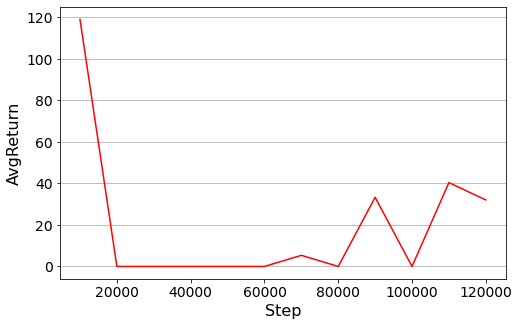

Steps: 130000  AvgReturn: 0


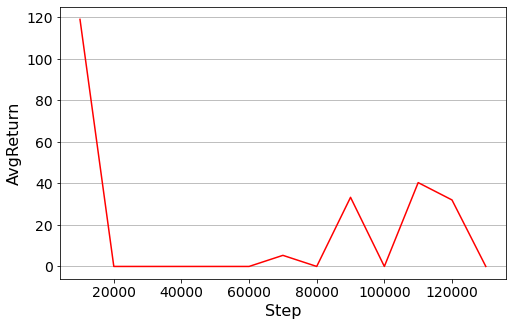

Steps: 140000  AvgReturn: 54.57264957264947


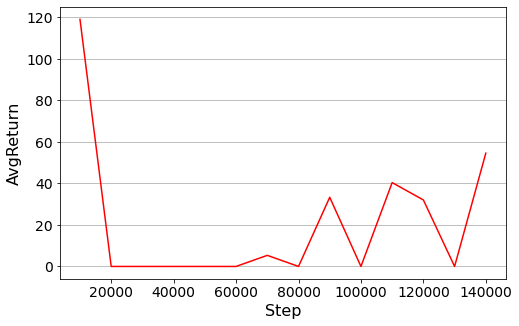

Steps: 150000  AvgReturn: 93.46153846154246


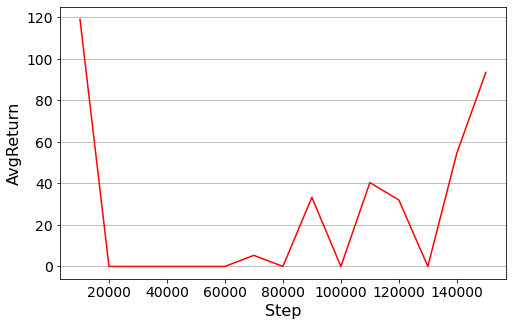

Steps: 160000  AvgReturn: 25.915032679738648


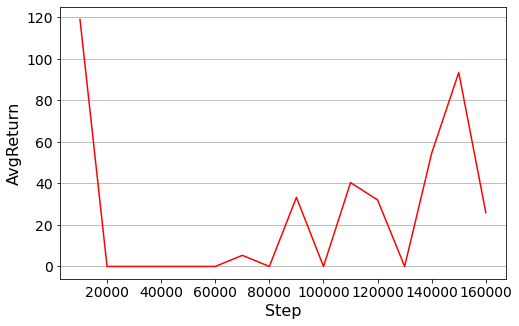

Steps: 170000  AvgReturn: 0


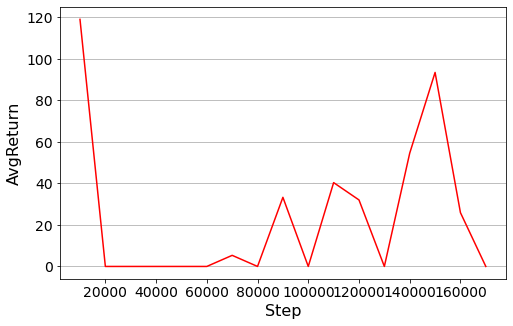

Steps: 180000  AvgReturn: 128.62869198312663


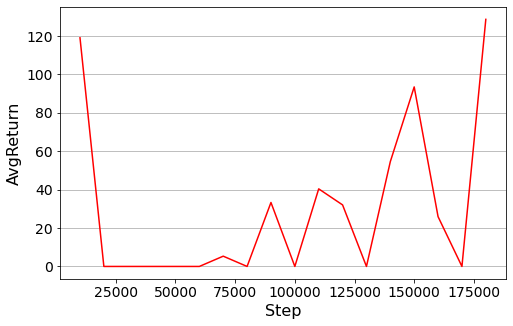

Steps: 190000  AvgReturn: 133.37370242214877


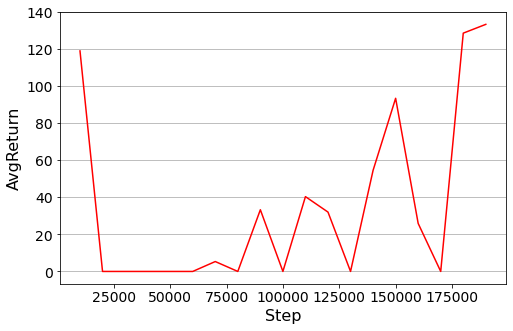

Steps: 200000  AvgReturn: 158.42465753424935


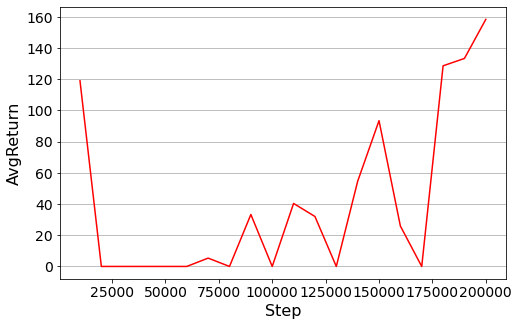

Steps: 210000  AvgReturn: 230.17482517482875


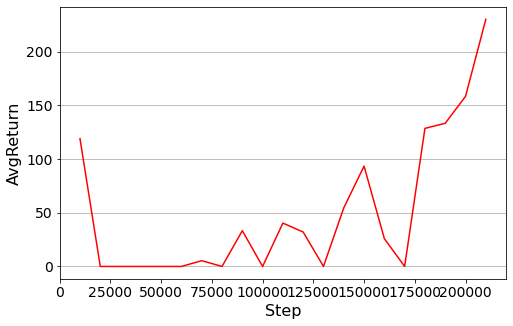

Steps: 220000  AvgReturn: 263.3617747440286


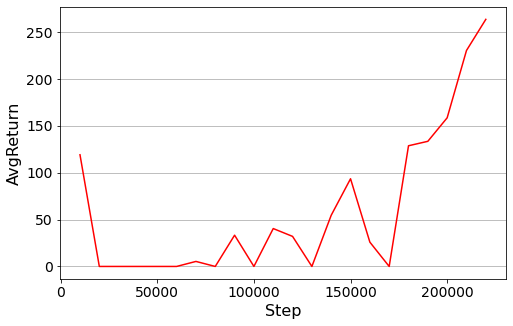

Steps: 230000  AvgReturn: 143.2550335570503


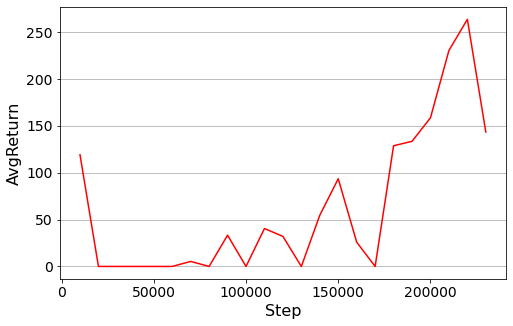

Steps: 240000  AvgReturn: 234.58801498127653


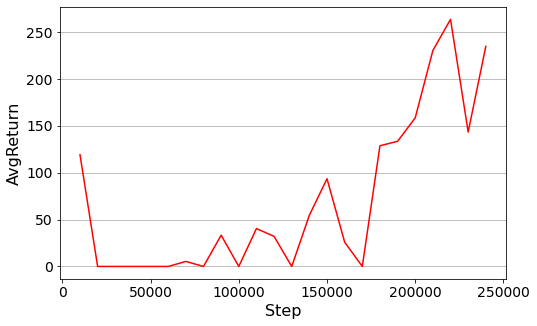

Steps: 250000  AvgReturn: 83.32167832167958


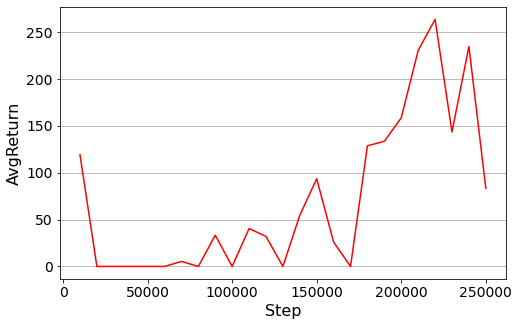

Steps: 260000  AvgReturn: 108.22580645161693


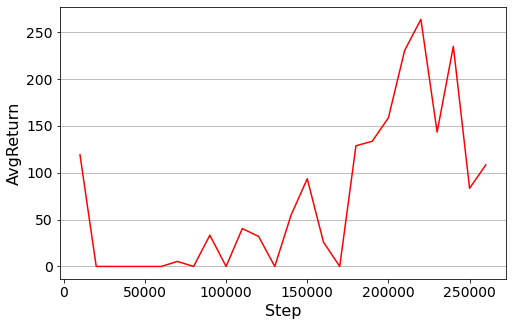

Steps: 270000  AvgReturn: 137.48407643312325


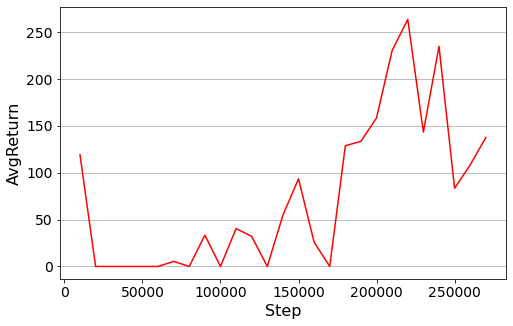

Steps: 280000  AvgReturn: 210.55555555555944


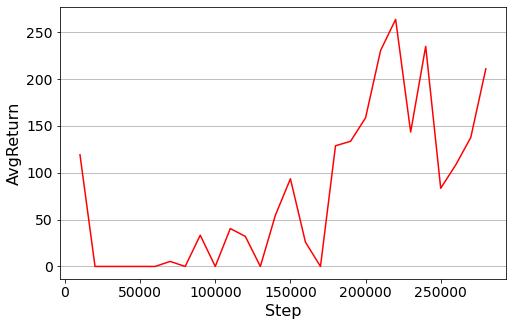

Steps: 290000  AvgReturn: 323.326693227078


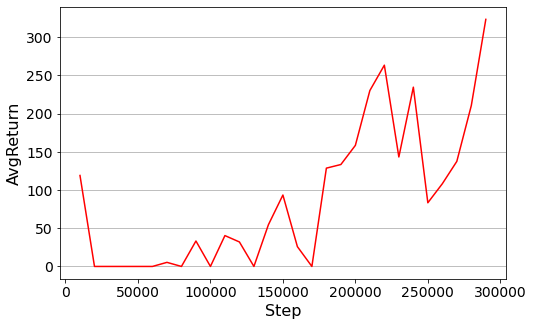

Steps: 300000  AvgReturn: 203.30508474576646


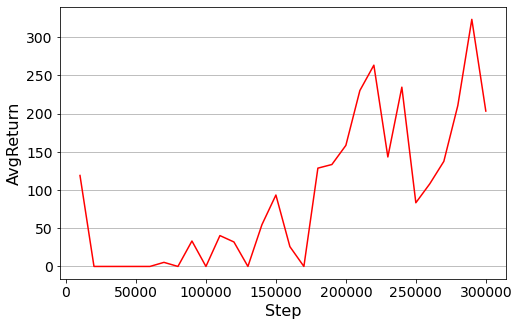

Steps: 310000  AvgReturn: 49.44444444444388


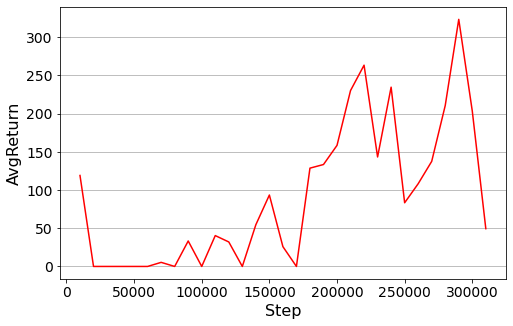

Steps: 320000  AvgReturn: 162.7319587628908


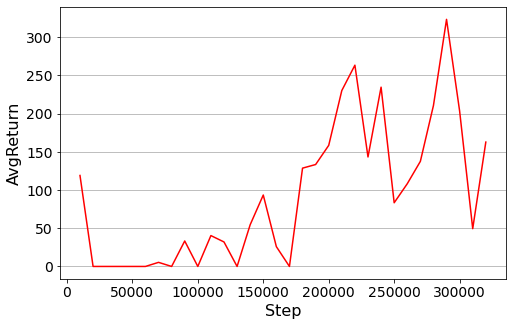

Steps: 330000  AvgReturn: 229.2320819112672


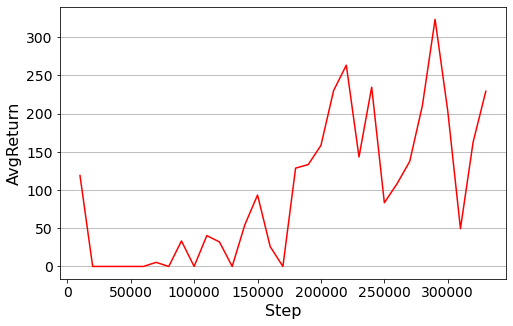

Steps: 340000  AvgReturn: 43.801261829656106


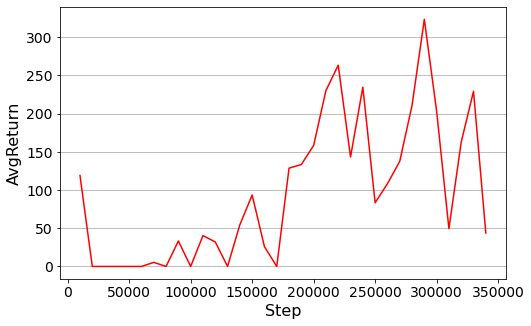

Steps: 350000  AvgReturn: 156.49700598802713


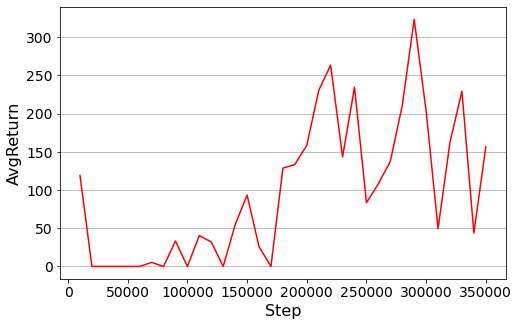

Steps: 360000  AvgReturn: 136.6176470588282


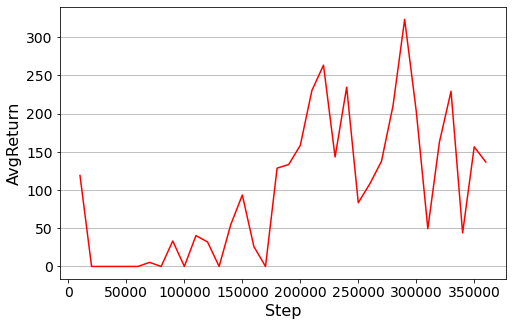

Steps: 370000  AvgReturn: 281.3066202090593


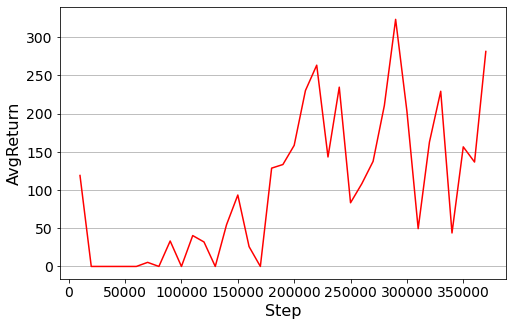

Steps: 380000  AvgReturn: 207.15827338129986


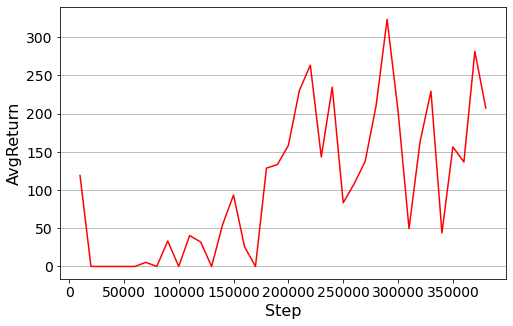

Steps: 390000  AvgReturn: 318.2841328413201


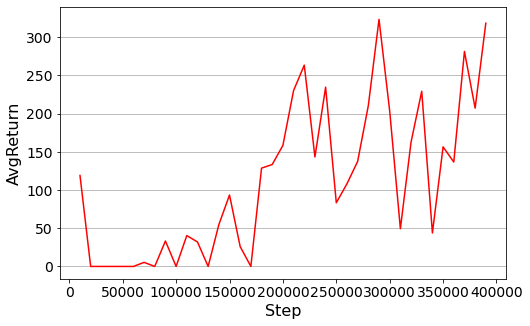

Steps: 400000  AvgReturn: 42.68115942029079


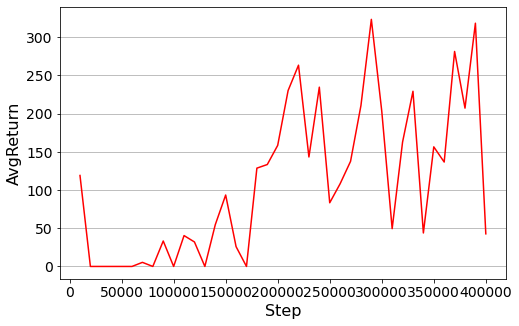

Steps: 410000  AvgReturn: 436.5985130111445


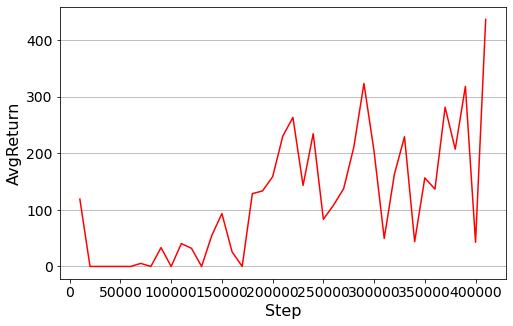

Steps: 420000  AvgReturn: 435.0751879699122


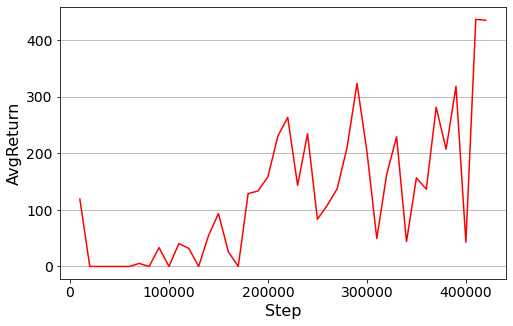

Steps: 430000  AvgReturn: 536.205673758857


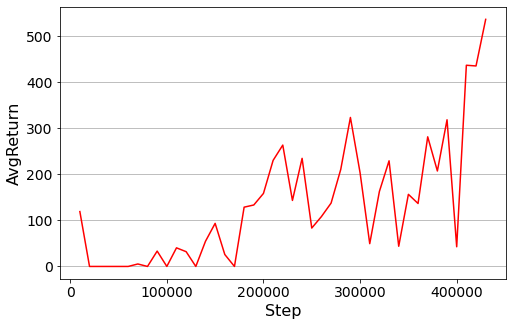

Steps: 440000  AvgReturn: 343.3561643835521


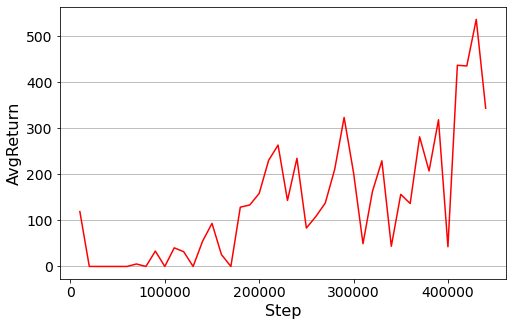

Steps: 450000  AvgReturn: 399.7735191637545


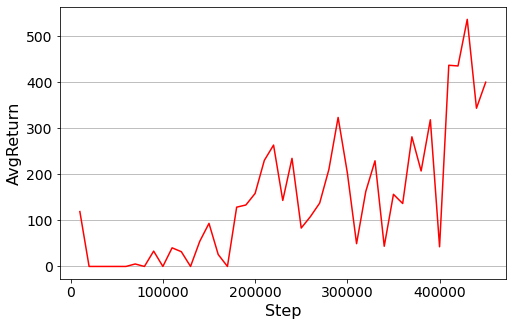

Steps: 460000  AvgReturn: 316.56462585033864


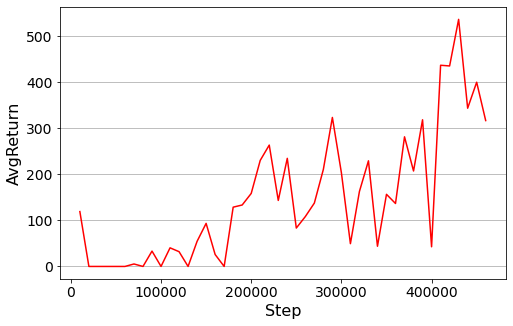

Steps: 470000  AvgReturn: 342.9310344827559


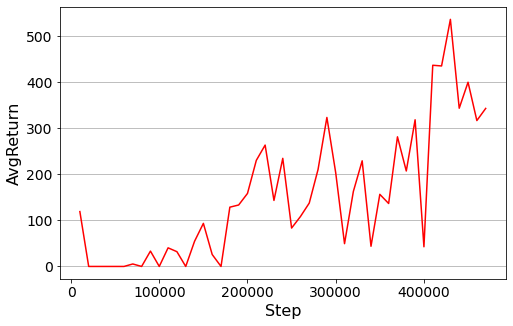

Steps: 480000  AvgReturn: 319.71571906353927


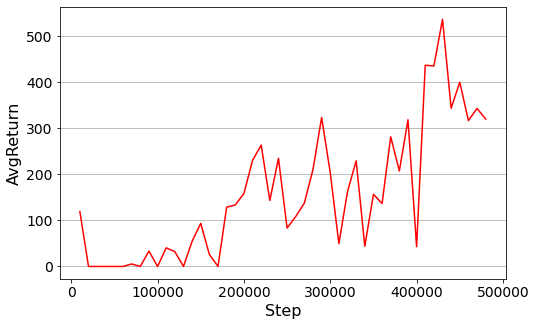

Steps: 490000  AvgReturn: 416.4503816793823


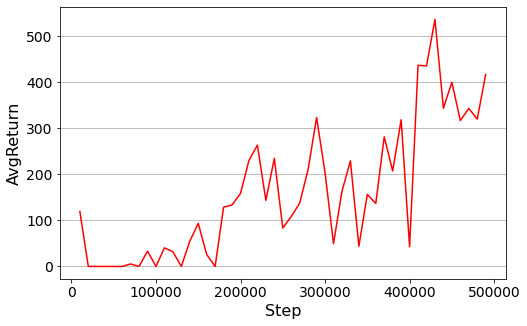

Steps: 500000  AvgReturn: 514.4890510948812


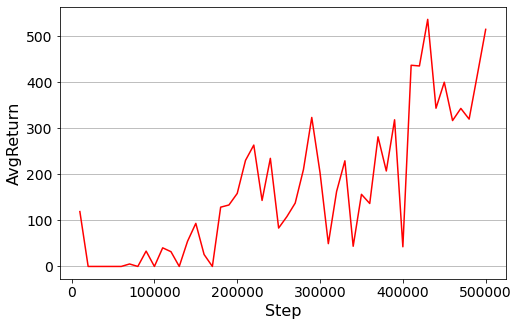

Steps: 510000  AvgReturn: 446.2186379928248


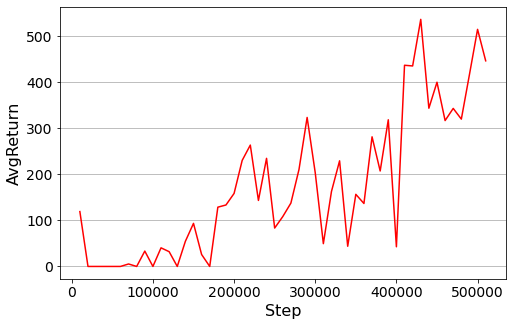

Steps: 520000  AvgReturn: 516.1111111111015


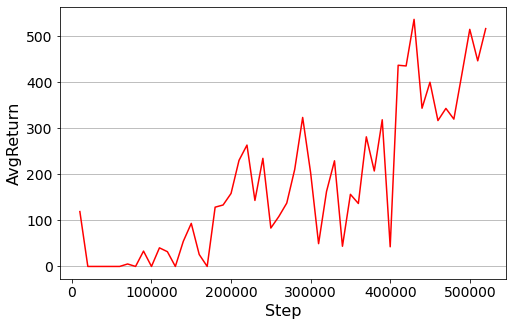

Steps: 530000  AvgReturn: 491.46616541352245


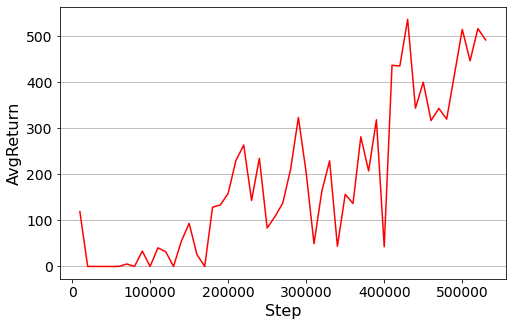

Steps: 540000  AvgReturn: 377.1189591077991


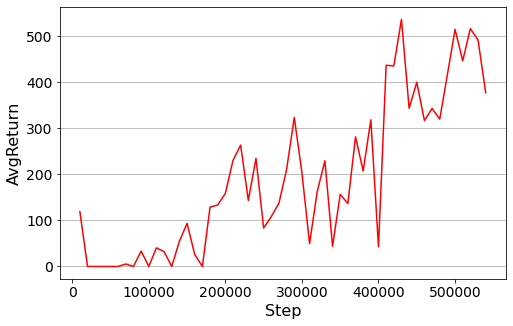

Steps: 550000  AvgReturn: 463.05243445691997


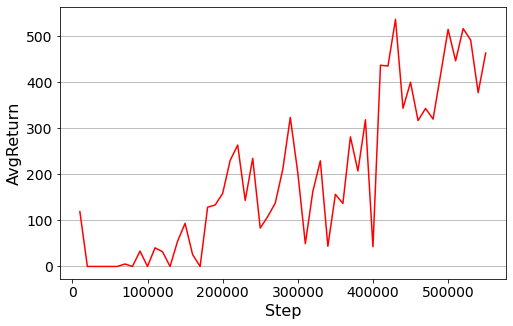

Steps: 560000  AvgReturn: 451.3576158940315


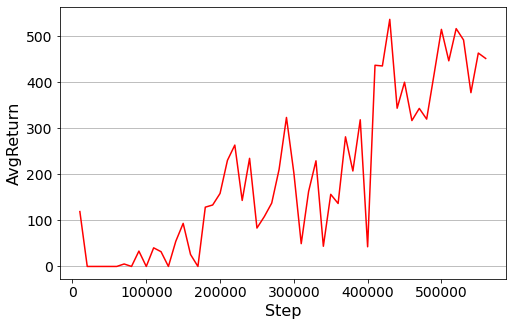

Steps: 570000  AvgReturn: 385.42704626334034


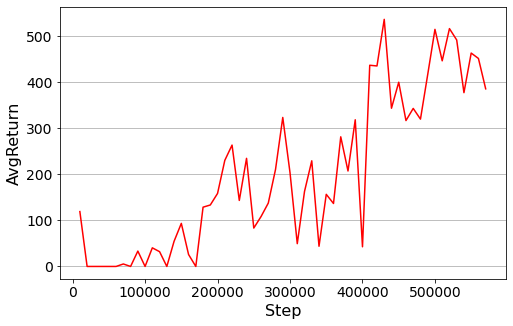

Steps: 580000  AvgReturn: 447.1686746987915


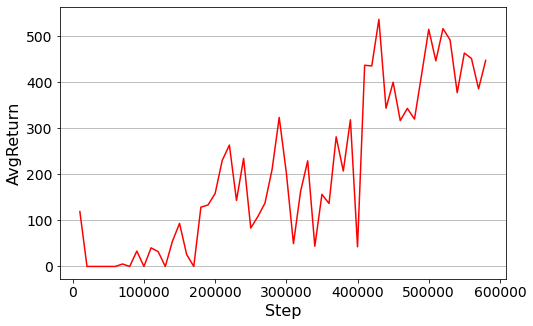

Steps: 590000  AvgReturn: 354.51140065146194


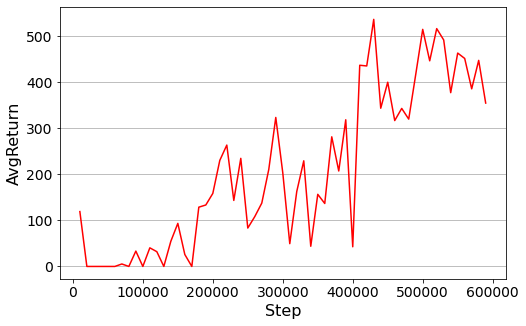

Steps: 600000  AvgReturn: 484.80456026057794


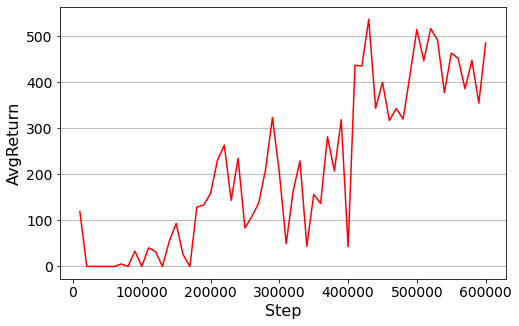

Steps: 610000  AvgReturn: 555.3496503496403


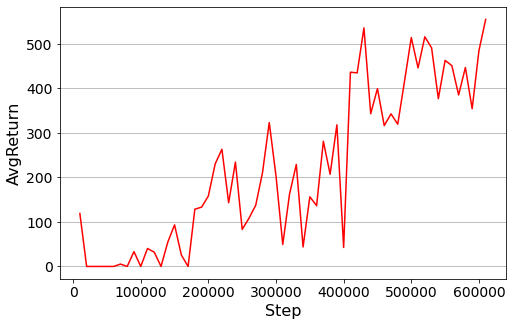

Steps: 620000  AvgReturn: 541.6906474820058


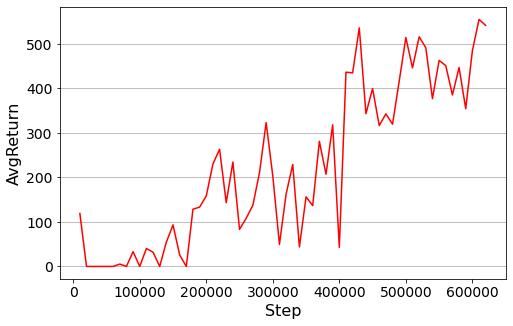

Steps: 630000  AvgReturn: 464.56678700360067


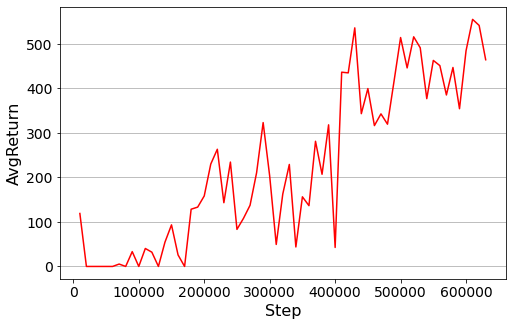

Steps: 640000  AvgReturn: 403.2078853046527


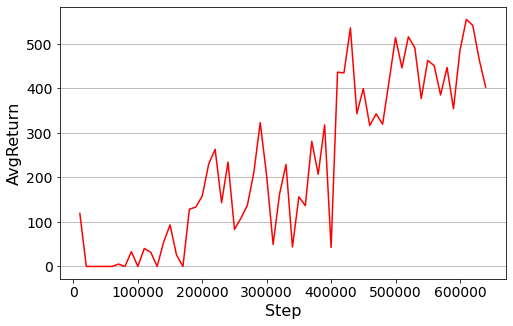

Steps: 650000  AvgReturn: 527.5680933852051


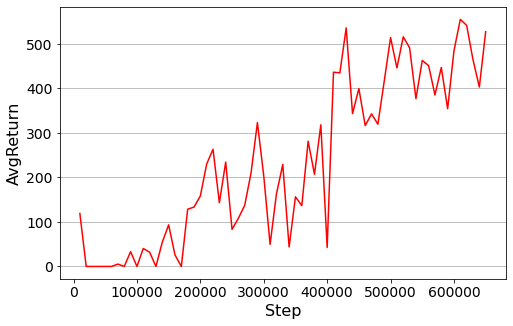

Steps: 660000  AvgReturn: 441.87315634217754


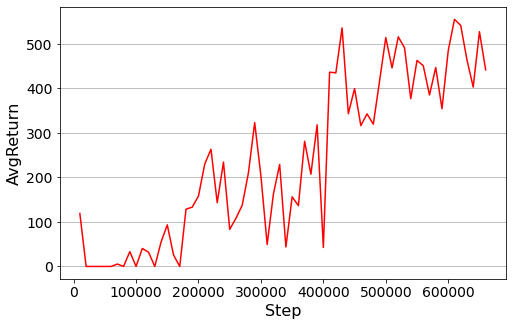

Steps: 670000  AvgReturn: 404.9999999999917


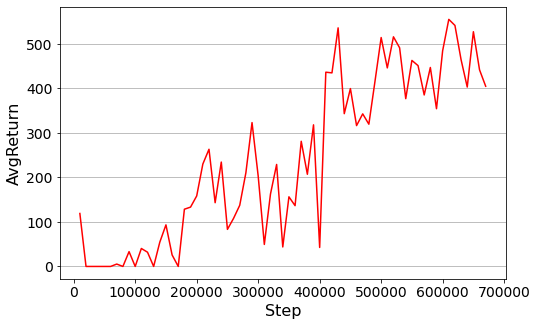

Steps: 680000  AvgReturn: 512.6923076922974


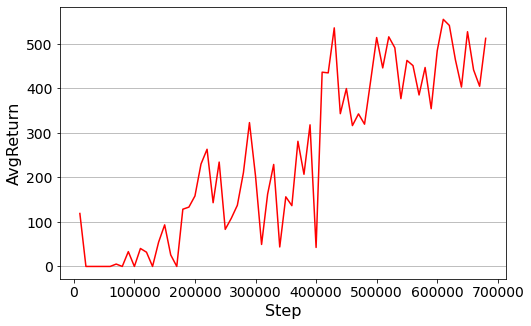

Steps: 690000  AvgReturn: 507.88808664258937


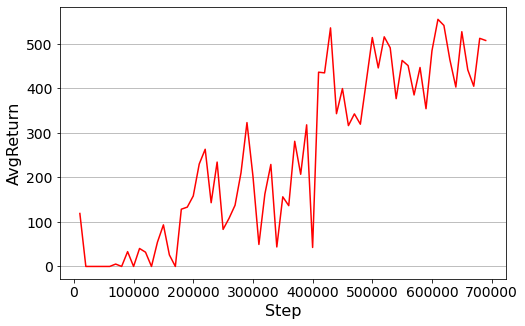

Steps: 700000  AvgReturn: 578.6842105263022


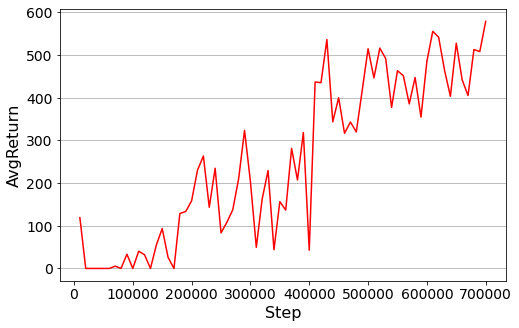

Steps: 710000  AvgReturn: 575.2127659574373


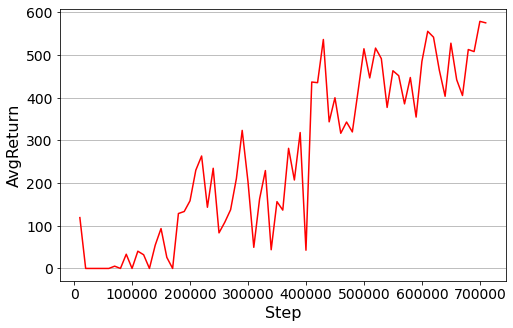

Steps: 720000  AvgReturn: 446.139240506319


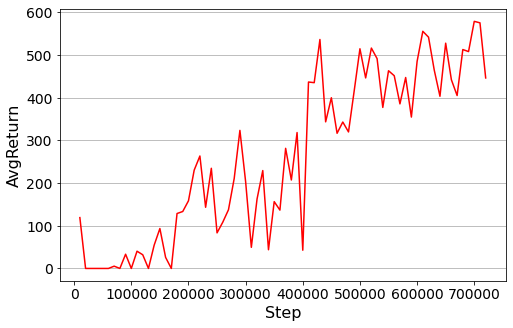

Steps: 730000  AvgReturn: 504.99999999998846


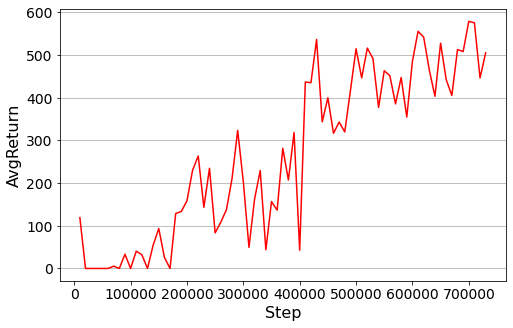

Steps: 740000  AvgReturn: 469.0138408304436


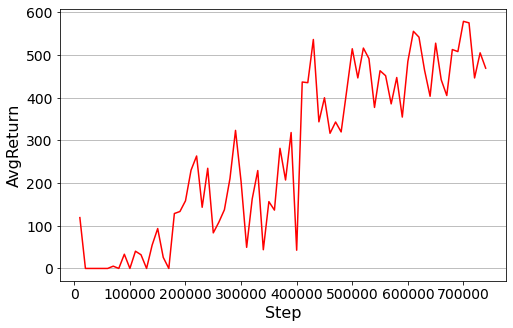

Steps: 750000  AvgReturn: 503.48484848484117


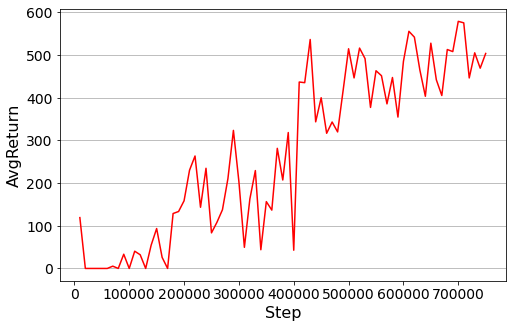

Steps: 760000  AvgReturn: 590.2589641434172


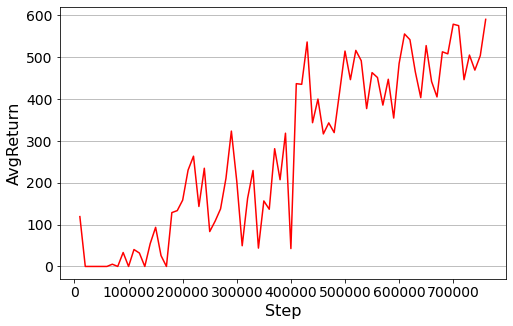

Steps: 770000  AvgReturn: 498.9849624060061


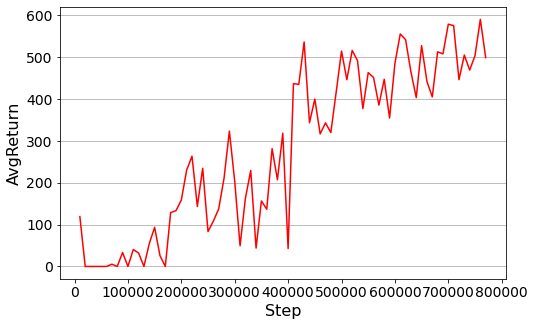

Steps: 780000  AvgReturn: 517.7819548872055


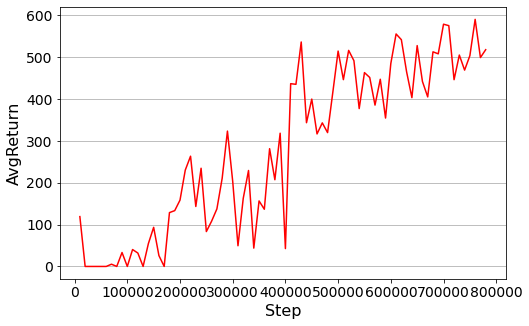

Steps: 790000  AvgReturn: 458.69127516777746


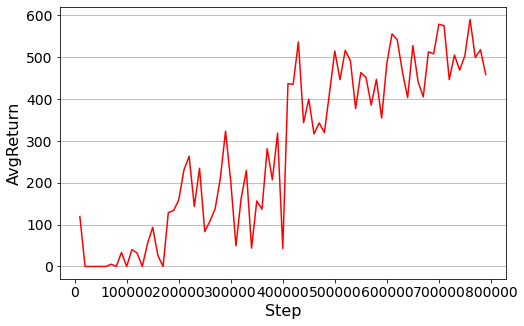

Steps: 800000  AvgReturn: 512.9734219269017


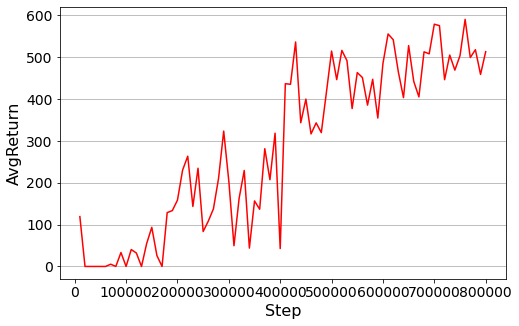

Steps: 810000  AvgReturn: 593.4057971014415


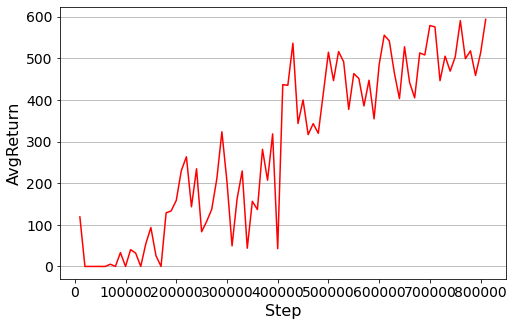

Steps: 820000  AvgReturn: 491.80555555554633


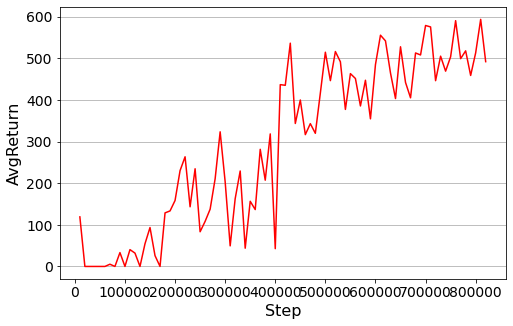

Steps: 830000  AvgReturn: 801.0573476702396


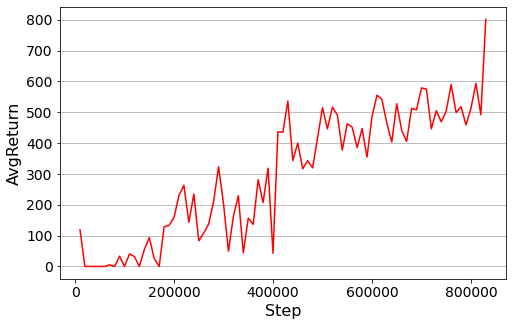

Steps: 840000  AvgReturn: 564.0163934426146


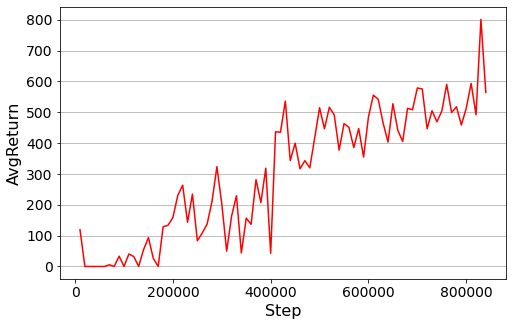

Steps: 850000  AvgReturn: 757.1400778210026


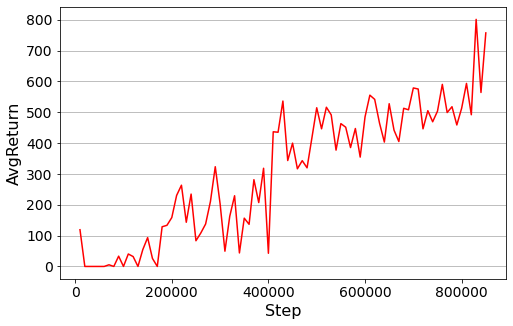

Steps: 860000  AvgReturn: 663.8932806324033


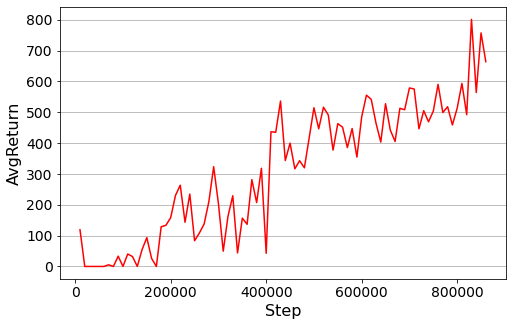

Steps: 870000  AvgReturn: 486.16883116882275


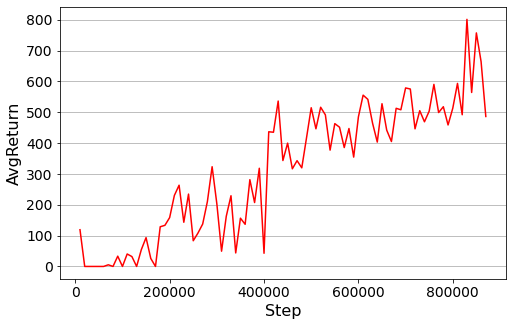

Steps: 880000  AvgReturn: 788.1615120274755


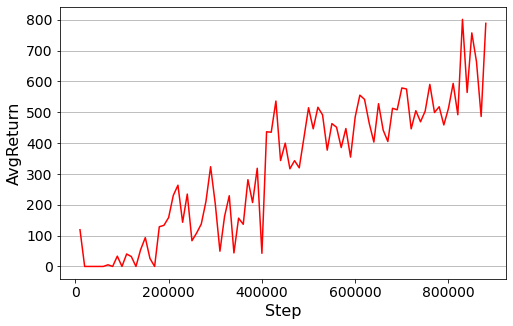

Steps: 890000  AvgReturn: 687.4561403508627


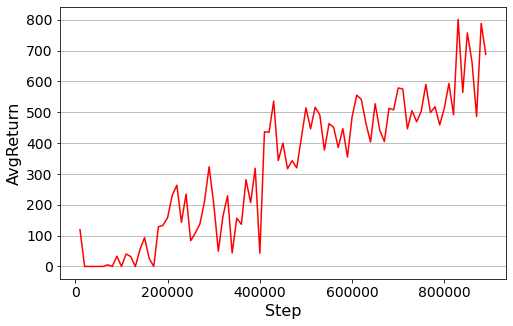

Steps: 900000  AvgReturn: 587.4324324324251


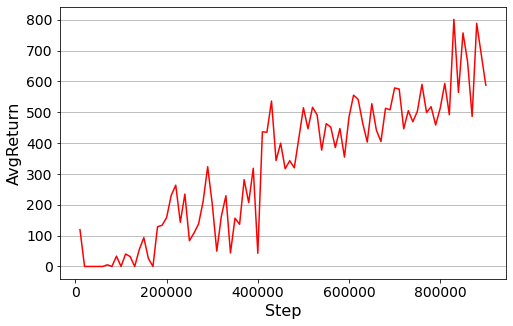

Steps: 910000  AvgReturn: 655.8196721311376


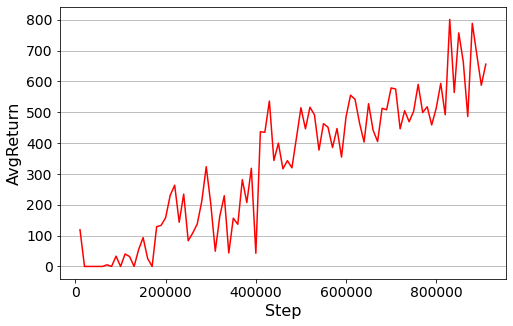

Steps: 920000  AvgReturn: 699.3262411347408


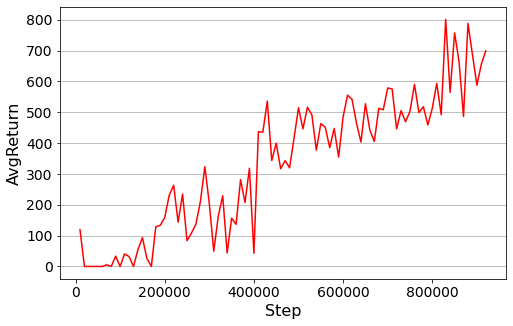

Steps: 930000  AvgReturn: 685.8219178082068


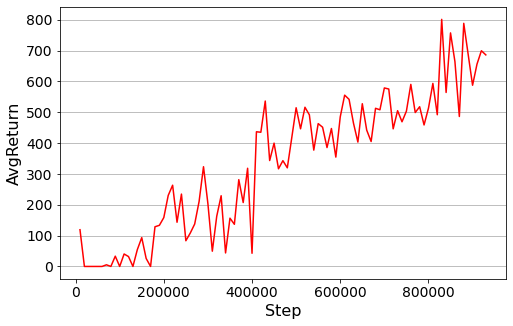

Steps: 940000  AvgReturn: 824.1919191919033


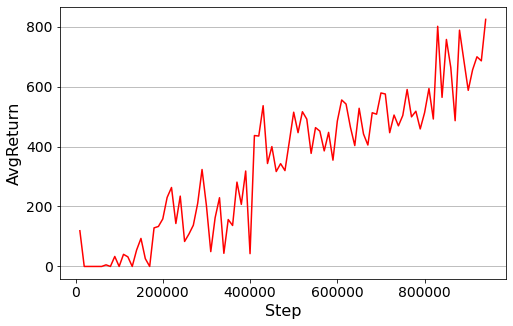

Steps: 950000  AvgReturn: 650.1612903225707


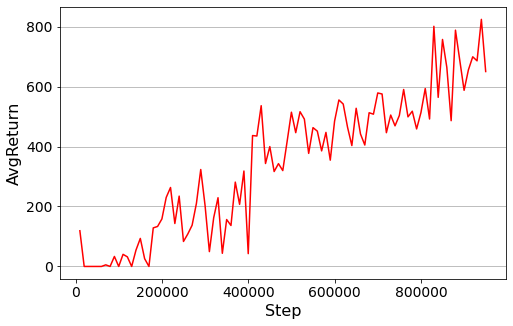

Steps: 960000  AvgReturn: 858.0201342281719


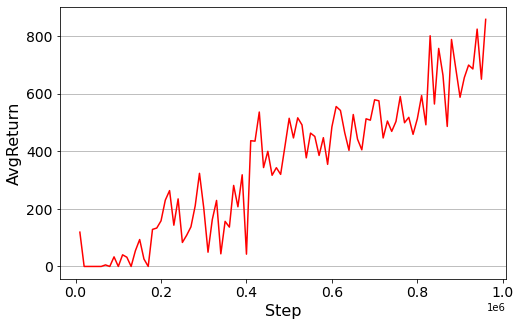

Steps: 970000  AvgReturn: 666.2903225806366


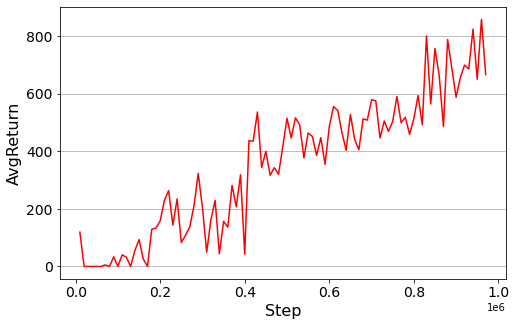

Steps: 980000  AvgReturn: 792.5968992247979


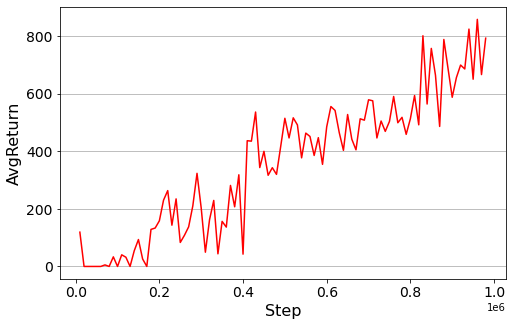

Steps: 990000  AvgReturn: 796.0891089108816


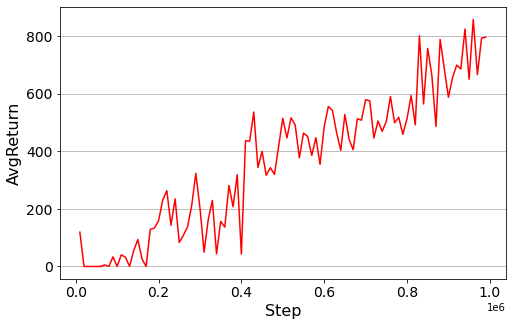

Steps: 1000000  AvgReturn: 864.5588235293944


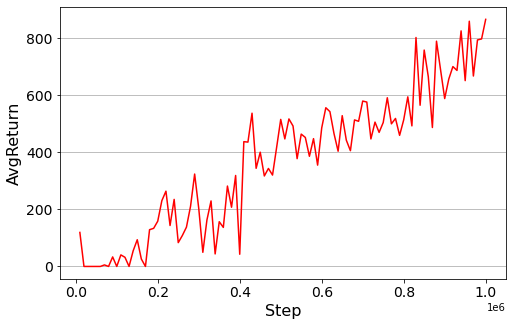

KeyboardInterrupt: 

In [13]:
history = {'Step': [], 'AvgReturn': []}
max_score=-1e6

(s,_)=env.reset()
while True:
  a=agent.select_action(s)
  ns, r, done, truncated, info = env.step(a)
  agent.process((s, a, r, ns, done))

  s=ns

  if done or truncated:
    (s,_)=env.reset()

  if agent.total_steps % eval_interval == 0:
    rewards = evaluate()
    
    print("Steps: {}  AvgReturn: {}".format(agent.total_steps,rewards))
    history['Step'].append(agent.total_steps)
    history['AvgReturn'].append(rewards)
    
    #clear_output()
    plt.figure(figsize=(8, 5))
    plt.plot(history['Step'], history['AvgReturn'], 'r-')
    plt.xlabel('Step', fontsize=16)
    plt.ylabel('AvgReturn', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y')
    plt.show()
    
    if rewards>max_score:
      max_score=rewards
      torch.save(agent.Q.state_dict(), 'duel_dqn.pt')


  if agent.total_steps > max_steps:
    break

# Testing

저장된 파라미터로 Evaluation을 해보시길 바랍니다.

출력 결과를 Capture해서 제출하세요


In [14]:
import datetime as dt
dt.datetime.now()
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = Dueling_DQN(state_dim, action_dim)
agent.Q.load_state_dict(torch.load("duel_dqn.pt"))
rewards = evaluate(n_evals=5)
print("Max Score: ",rewards)

Max Score:  885.8429118773853
